In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import main
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.neighbors import DistanceMetric
from pandas.plotting import lag_plot
from sklearn.cluster import DBSCAN
from scipy.integrate import odeint

data from https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data/resource/260bbbde-2316-40eb-aec3-7cd7bfc2f590

In [14]:
data = main.getdata('data/timeseries25May.csv')

In [15]:
data = data.loc[data['country'].isin(['Netherlands', 'Belgium', 'Italy', 'Sweden', 'Denmark', 'Norway', 'Spain', 'United_Kingdom', 'Germany', 'Romania'])]

In [16]:
len(data['country'].unique())

10

Check for missing data

In [17]:
datelist = [date for date in pd.date_range(start='2019-12-31', end='2020-05-25') if len(data.loc[data['date'] == date]) != 10]

In [18]:
missing = [[(country, date.ctime()) for country in ['Netherlands', 'Belgium', 'Italy', 'Sweden', 'Denmark', 'Norway', 'Spain', 'United_Kingdom', 'Germany', 'Romania'] if country not in list(data.loc[data['date'] == date]['country'].values)] for date in datelist]

In [19]:
missing

[[('Romania', 'Tue Mar  3 00:00:00 2020')],
 [('Romania', 'Thu Mar  5 00:00:00 2020')],
 [('Spain', 'Mon May 25 00:00:00 2020')]]

Check for negative values

In [20]:
negative = data.loc[data['cases'] < 0]
negative

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp
16493,2020-04-19,19,4,2020,-713,410,Spain,ES,ESP,46723749.0,Europe
18258,2020-05-21,21,5,2020,-525,363,United_Kingdom,UK,GBR,66488991.0,Europe


In [21]:
data = data.drop(negative.index.values)

In [22]:
data.loc[data['cases'] < 0]

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp


Add columns for cases of yesterday and predictions of yesterday. 

In [13]:
data = data.assign(expcasesyest=np.nan, casesyest=np.nan)

In [14]:
for country in data['country'].unique(): 
    data.loc[data['country']==country, 'casesyest'] = data.loc[data['country']==country].cases.shift(1)

In [15]:
data.head()

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp,expcasesyest,casesyest
18400,2019-12-31,31,12,2019,0,0,United_Kingdom,UK,GBR,66488991.0,Europe,NaN,NaN
4966,2019-12-31,31,12,2019,0,0,Denmark,DK,DNK,5797446.0,Europe,NaN,NaN
6990,2019-12-31,31,12,2019,0,0,Germany,DE,DEU,82927922.0,Europe,NaN,NaN
9337,2019-12-31,31,12,2019,0,0,Italy,IT,ITA,60431283.0,Europe,NaN,NaN
1979,2019-12-31,31,12,2019,0,0,Belgium,BE,BEL,11422068.0,Europe,NaN,NaN


Separate countries, make sure first record is equal to the first case date, reindex dataframes and set the first expcasesyest to 0. 

In [23]:
nl=no=be=ge=de=se=ro=it=uk=sp= None
countries = [[nl, 'Netherlands'], [no, 'Norway'], [be, 'Belgium'], [ge, 'Germany'], [de, 'Denmark'], [se, 'Sweden'], [ro, 'Romania'], [it, 'Italy'], [uk, 'United_Kingdom'], [sp, 'Spain']]
for country in countries: 
    country[0] = data.loc[data['country'] == country[1]]
    country[0].drop(country[0].loc[country[0]['cases']==0].index, inplace=True)
    country[0].reset_index(drop=True, inplace=True)
#     country[0].loc[0,'expcasesyest']=0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [24]:
dataframes, _ = zip(*countries)

In [25]:
dataframes[0].head()

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp
0,2020-02-28,28,2,2020,1,0,Netherlands,NL,NLD,17231017.0,Europe
1,2020-02-29,29,2,2020,1,0,Netherlands,NL,NLD,17231017.0,Europe
2,2020-03-01,1,3,2020,5,0,Netherlands,NL,NLD,17231017.0,Europe
3,2020-03-02,2,3,2020,6,0,Netherlands,NL,NLD,17231017.0,Europe
4,2020-03-03,3,3,2020,5,0,Netherlands,NL,NLD,17231017.0,Europe


## Seir Model

https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/, 
https://arxiv.org/pdf/2003.11150.pdf

In [192]:
mobility = np.asarray([[0.08, 0.02, 0.15, 0.15, 0.15, 0.1, 0.15, 0.2], [0.08, 0.02, 0.15, 0.15, 0.15, 0.1, 0.15, 0.2], [0.3, 0.3, 0.1, 0.1, 0.05, 0.05, 0, 0.1], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]])
beta = 0.1
betaArr = [0.08, beta, 1.5*beta, 1.5*beta, 1.5*beta, 1.5*beta, beta, 3*beta]
q = 3
delta = 0.15
d = 0.016
g = 0.0167
gammaR = 0.08
gammaD = 0.12
t = np.linspace(0, 500, 48000)
# N = np.unique(dataframes[0]['pop'].values)[0]
N = 1000
I0 = dataframes[0]['cases'].values[0]
R0 = D0 = 0
E0 = 10
S0 = N - I0 - R0 - E0 - D0
y0 = S0, E0, I0, R0, D0

In [201]:
mobility = np.asarray([[0.08, 0.02, 0.15, 0.15, 0.15, 0.1, 0.15, 0.2], [0.08, 0.02, 0.15, 0.15, 0.15, 0.1, 0.15, 0.2], [0.3, 0.3, 0.1, 0.1, 0.05, 0.05, 0, 0.1], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]])
beta = 0.5
betaArr = [0.08, beta, 1.5*beta, 1.5*beta, 1.5*beta, 1.5*beta, beta, 3*beta]
q = 3
delta = 0.15
d = 0.016
g = 0.0167
gammaR = 0.08
gammaD = 0.3
t = np.linspace(0, 500, 48000)
# N = np.unique(dataframes[0]['pop'].values)[0]
N = 1000
I0 = dataframes[0]['cases'].values[0]
R0 = D0 = 0
E0 = 10
S0 = N - I0 - R0 - E0 - D0
y0 = S0, E0, I0, R0, D0

In [202]:
def deriv(y, t, N, betaArr, mobility, delta, d, g, q, gammaR, gammaD):
    S, E, I, R, D = y
    dSdt = dEdt = dIdt = 0
    for i in range(8):
        dSdt = dSdt + (-betaArr[i]*S * mobility[:,i][0] *(I*mobility[:,i][2]-q*E * mobility[:,i][1])/N + d*E * mobility[:,i][1] + g*I * mobility[:,i][2])
        dEdt = dEdt + (betaArr[i]*S * mobility[:,i][0]*(I*mobility[:,i][2]-q*E*mobility[:,i][1])/N - (delta + d)*E* mobility[:,i][1])
        dIdt = dIdt + (delta*E *mobility[:,i][1] - (gammaR + gammaD)*I* mobility[:,i][2])
        
#     dSdt = -beta*S*(I-q*E)/N + d*E + g*I
#     dEdt = beta*S*(I-q*E)/N - (delta + d)*E
#     dIdt = delta*E - (gammaR + gammaD)*I
#     print(dSdt, dEdt, dIdt)
    dRdt = gammaR * I - g*R
    dDdt = gammaD*I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [203]:
ret = odeint(deriv, y0, t, args=(N, betaArr, mobility, delta, d, g, q, gammaR, gammaD))
S, E, I, R, D = ret.T

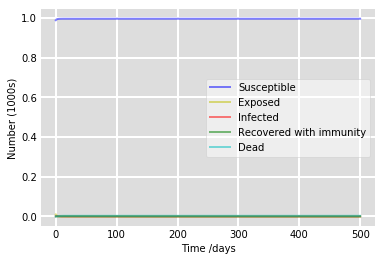

In [204]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, E/1000, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.plot(t, D/1000, 'c', alpha=0.5, lw=2, label='Dead')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [180]:
S = [S0]
E = [E0]
I = [I0]
R = [R0]
D = [D0]
def euler(f,y0,a,b,h):
    t,y = a,y0
    i = 0
    while t <= b:
        i += i
        t += h
        y += h * np.asarray(f(y, t, N, betaArr, mobility, delta, d, g, q, gammaR, gammaD))
        S.append(y[0])
        E.append(y[1])
        I.append(y[2])
        R.append(y[3])
        D.append(y[4])
    return S, E, I, R, D
        
        
S, E, I, R, D = euler(deriv,y0,0,500,0.01)

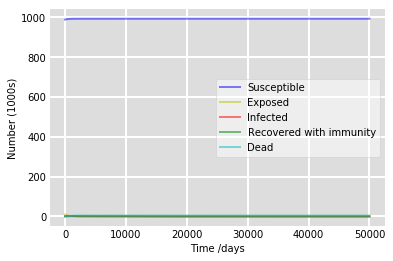

In [181]:
x = np.linspace(0, len(S), len(S))
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(x, np.asarray(S), 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(x, E, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(x, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(x, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.plot(x, D, 'c', alpha=0.5, lw=2, label='Dead')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()